In [2]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import numpy as np
import pandas as pd

from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn import preprocessing

from statsmodels.tsa.stattools import coint

from scipy import stats

from quantopian.pipeline.data import morningstar
from quantopian.pipeline.filters.morningstar import Q500US, Q1500US, Q3000US
from quantopian.pipeline import Pipeline
from quantopian.research import run_pipeline

In [3]:
universe = Q1500US()

pipe = Pipeline(
    columns= {
        'Market Cap': morningstar.valuation.market_cap.latest.quantiles(5),
        'Industry': morningstar.asset_classification.morningstar_industry_group_code.latest,
        'Financial Health': morningstar.asset_classification.financial_health_grade.latest
    },
    screen=universe
)

study_date = "2020-01-01"

res = run_pipeline(pipe, study_date, study_date)
res.index = res.index.droplevel(0)  # drop the single date from the multi-index

In [4]:
res.head()

,Financial Health,Industry,Market Cap
Equity(2 [ARNC]),B,31070,4
Equity(24 [AAPL]),A,31120,4
Equity(53 [ABMD]),B,20650,4
Equity(62 [ABT]),A,20650,4
Equity(67 [ADSK]),B,31110,4


In [5]:
# remove stocks in Industry "Conglomerates"
res = res[res['Industry']!=31055]
print res.shape

(1500, 3)


In [6]:
# remove stocks without a Financial Health grade
res = res[res['Financial Health']!= None]
print res.shape

(1498, 3)


In [7]:
# replace the categorical data with numerical scores per the docs
res['Financial Health'] = res['Financial Health'].astype('object')
health_dict = {u'A': 0.1,
               u'B': 0.3,
               u'C': 0.7,
               u'D': 0.9,
               u'F': 1.0}
res = res.replace({'Financial Health': health_dict})

res.describe()

,Financial Health,Industry,Market Cap
count,1498.000000,1498.000000,1498.000000
mean,0.448999,20824.042056,3.465287
std,0.269619,9098.953897,0.620672
min,0.100000,10110.000000,2.000000
25%,0.300000,10340.000000,3.000000
50%,0.300000,20630.000000,4.000000
75%,0.700000,31040.000000,4.000000
max,1.000000,31130.000000,4.000000


In [8]:
pricing = get_pricing(
    symbols=res.index,
    fields='close_price',
    start_date=pd.Timestamp(study_date) - pd.DateOffset(months=24),
    end_date=pd.Timestamp(study_date)
)

In [9]:
pricing.head()

,Equity(2 [ARNC]),Equity(24 [AAPL]),Equity(53 [ABMD]),Equity(62 [ABT]),Equity(67 [ADSK]),Equity(76 [TAP]),Equity(110 [RAMP]),Equity(114 [ADBE]),Equity(122 [ADI]),Equity(128 [ADM]),...,Equity(53304 [ADPT]),Equity(53313 [REAL]),Equity(53314 [KRTX]),Equity(53362 [MDLA]),Equity(53379 [LVGO]),Equity(53403 [DT]),Equity(53478 [SDC]),Equity(53498 [NVST]),Equity(53511 [DDOG]),Equity(53535 [PTON])
2018-01-02 00:00:00+00:00,27.294,167.191,192.43,56.790,107.10,77.379,28.10,177.69,86.730,37.597,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-03 00:00:00+00:00,27.501,167.123,195.77,56.906,109.36,76.635,28.26,180.98,87.748,37.325,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-04 00:00:00+00:00,28.828,167.938,199.30,56.819,112.09,77.190,28.21,183.21,87.671,37.944,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-05 00:00:00+00:00,29.104,169.831,202.28,56.983,110.82,78.018,28.10,185.35,88.007,37.682,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-08 00:00:00+00:00,29.251,169.219,207.80,56.838,111.41,78.903,28.27,185.02,88.199,37.597,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
pricing.shape

(503, 1498)

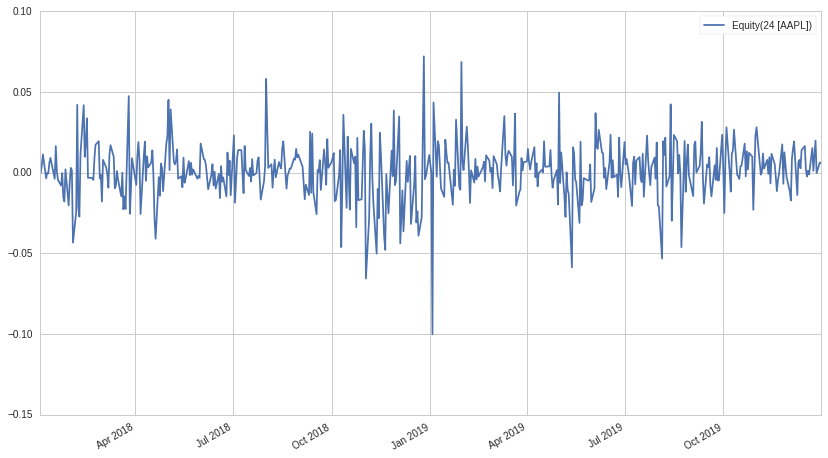

In [11]:
returns = pricing.pct_change()
returns[symbols(['AAPL'])].plot();

In [12]:
# Only work with stocks that have the full return series
returns = returns.iloc[1:,:].dropna(axis=1)
print returns.shape

(502, 1367)


In [13]:
returns.head()

,Equity(2 [ARNC]),Equity(24 [AAPL]),Equity(53 [ABMD]),Equity(62 [ABT]),Equity(67 [ADSK]),Equity(76 [TAP]),Equity(114 [ADBE]),Equity(122 [ADI]),Equity(128 [ADM]),Equity(161 [AEP]),...,Equity(51281 [CARG]),Equity(51314 [MDB]),Equity(51338 [EYE]),Equity(51350 [FSCT]),Equity(51367 [ALTR]),Equity(51379 [FNKO]),Equity(51428 [BAND]),Equity(51467 [SFIX]),Equity(51468 [SAIL]),Equity(51494 [DLPH])
2018-01-03 00:00:00+00:00,0.007584,-0.000407,0.017357,0.002043,0.021102,-0.009615,0.018515,0.011738,-0.007235,-0.008839,...,-0.005317,-0.002053,-0.008940,-0.034550,0.033017,-0.025797,0.006849,-0.008074,0.017422,-0.020159
2018-01-04 00:00:00+00:00,0.048253,0.004877,0.018031,-0.001529,0.024963,0.007242,0.012322,-0.000878,0.016584,-0.011692,...,0.002339,-0.003428,-0.008018,-0.044482,-0.005194,-0.010903,0.002551,0.032153,-0.015068,0.045961
2018-01-05 00:00:00+00:00,0.009574,0.011272,0.014952,0.002886,-0.011330,0.010727,0.011681,0.003833,-0.006905,-0.002535,...,0.000000,-0.002408,-0.016923,0.012601,0.004016,-0.036220,-0.002545,0.014748,0.020862,0.000523
2018-01-08 00:00:00+00:00,0.005051,-0.003604,0.027289,-0.002545,0.005324,0.011344,-0.001780,0.002182,-0.002256,0.009031,...,0.011333,-0.006207,-0.000257,0.035949,0.016400,0.004902,-0.004677,0.030543,0.035422,-0.010966
2018-01-09 00:00:00+00:00,0.002359,-0.000059,0.009432,0.000862,0.006193,-0.002750,0.009242,-0.002177,0.003484,-0.011619,...,0.006922,-0.001735,-0.024415,0.018685,0.046832,0.000000,-0.004699,-0.047134,-0.006579,0.035269


# PCA

Reducing the number of equities through PCA

In [14]:
pca = PCA(n_components=50)
pca.fit(returns)

/venvs/py35/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)


PCA(copy=True, n_components=50, whiten=False)

In [15]:
pca.components_.T.shape

(1367, 50)

In [16]:
X = np.hstack(
    (pca.components_.T,
     res['Market Cap'][returns.columns].values[:, np.newaxis],
     res['Financial Health'][returns.columns].values[:, np.newaxis])
)

print(X.shape)

(1367, 52)


In [17]:
X = preprocessing.StandardScaler().fit_transform(X)
print X.shape

(1367, 52)


# DBSCAN


In [18]:
clf = DBSCAN(eps=1.9, min_samples=3)
print clf

clf.fit(X)
labels = clf.labels_

# Take out outliers that don't fit in any cluster
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

print "\nClusters discovered: %d" % n_clusters_

/venvs/py35/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/venvs/py35/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)


DBSCAN(algorithm='auto', eps=1.9, leaf_size=30, metric='euclidean',
    min_samples=3, p=None, random_state=None)

Clusters discovered: 17


In [19]:
# the initial dimensionality of the search was
ticker_count = len(returns.columns)
print "Total pairs possible in universe: %d " % (ticker_count*(ticker_count-1)/2)

Total pairs possible in universe: 933661 


In [20]:
clustered = clf.labels_
clustered_series = pd.Series(index=returns.columns, data=clustered.flatten())
clustered_series = clustered_series[clustered_series != -1]

counts = clustered_series.value_counts()
counts.head()

7    35
8    23
0    22
3    17
1    16
dtype: int64

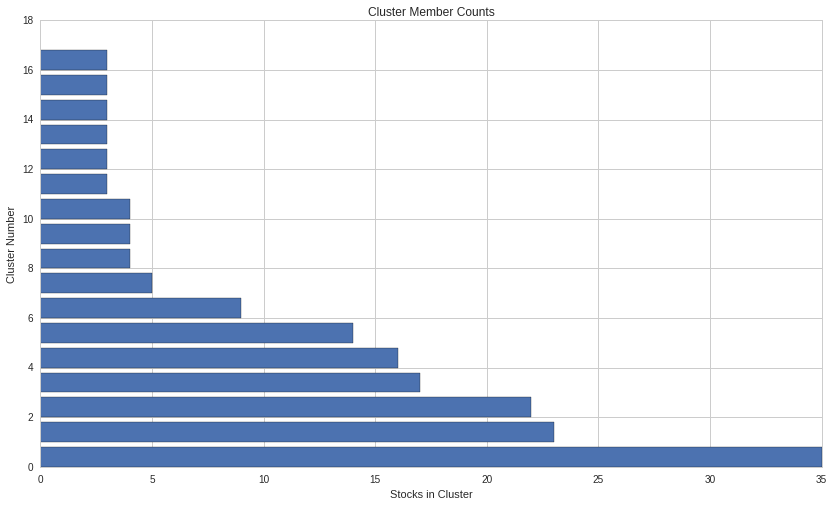

In [21]:
plt.barh(
    range(len(clustered_series.value_counts())),
    clustered_series.value_counts()
)
plt.title('Cluster Member Counts')
plt.xlabel('Stocks in Cluster')
plt.ylabel('Cluster Number');


In [22]:
print "Clusters formed: %d" % len(counts)
print "Pairs to evaluate: %d" % (counts*(counts-1)).sum()

Clusters formed: 17
Pairs to evaluate: 3016


In [23]:
print "We have reduced the search space for pairs from 933661 to approximately: %d" % (counts*(counts-1)).sum()

We have reduced the search space for pairs from 933661 to approximately: 3016


# t-SNE

Reduce 52 dimensions into 2-d.  Visualize the discover pairs


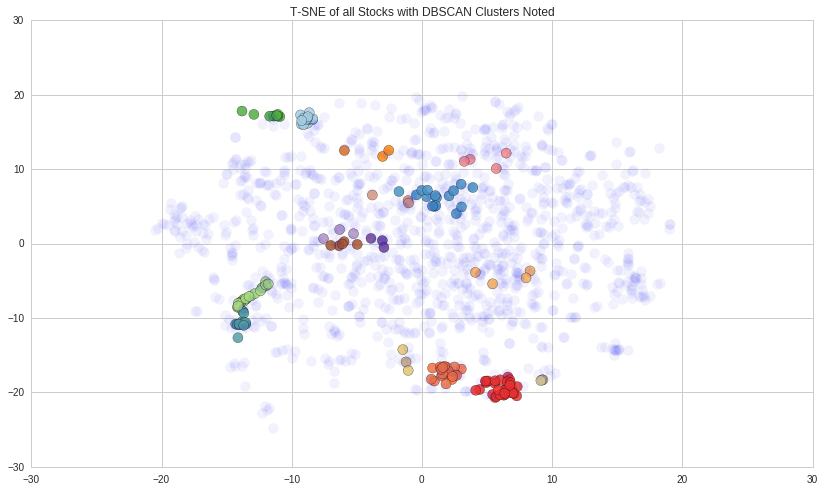

In [34]:
clustered_series_all = pd.Series(index=returns.columns, data=clustered.flatten())

X_tsne = TSNE(learning_rate=1000, perplexity=25, random_state=1337).fit_transform(X)

plt.figure(1, facecolor='white')
# plt.clf()
plt.axis('off')

plt.scatter(
    X_tsne[(labels!=-1), 0],
    X_tsne[(labels!=-1), 1],
    s=100,
    alpha=0.85,
    c=labels[labels!=-1],
    cmap=cm.Paired
)

plt.scatter(
    X_tsne[(clustered_series_all==-1).values, 0],
    X_tsne[(clustered_series_all==-1).values, 1],
    s=100,
    alpha=0.05
)

plt.title('T-SNE of all Stocks with DBSCAN Clusters Noted');


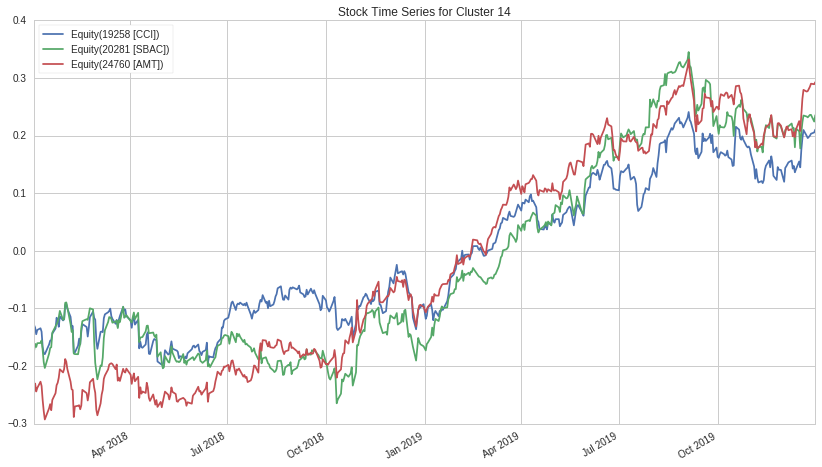

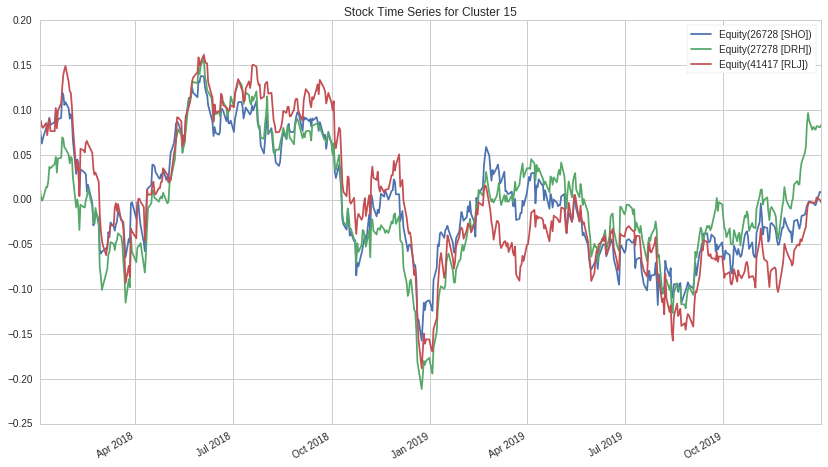

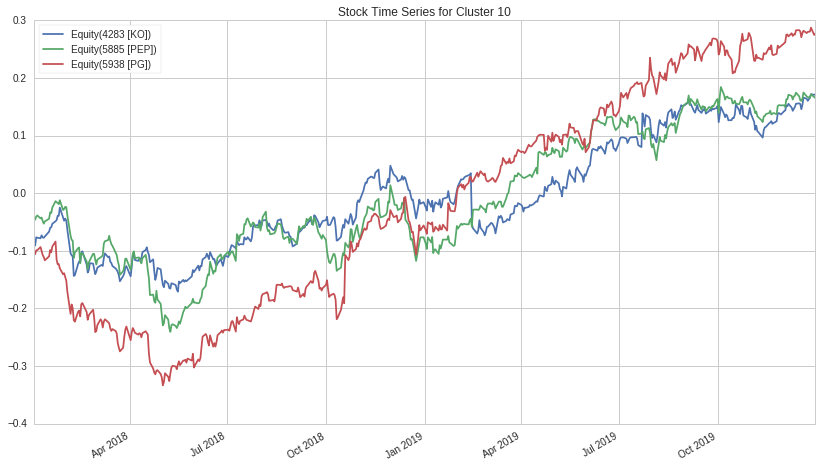

In [66]:
# get the number of stocks in each cluster
counts = clustered_series.value_counts()

# Visualize some clusters
    # Cluster label index => List => Reverse order within the list
cluster_vis_list = list(counts[(counts<20) & (counts>1)].index)[::-1]

# plot a handful of the smallest clusters
for clust in cluster_vis_list[0:3]:
# for clust in cluster_vis_list[0:min(len(cluster_vis_list), 3)]:
    tickers = list(clustered_series[clustered_series==clust].index)
    means = np.log(pricing[tickers].mean())
    data = np.log(pricing[tickers]).sub(means)
    data.plot(title='Stock Time Series for Cluster %d' % clust)


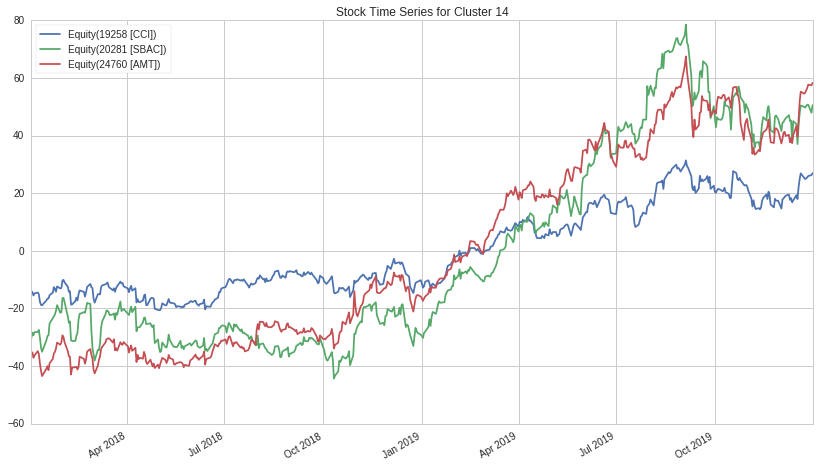

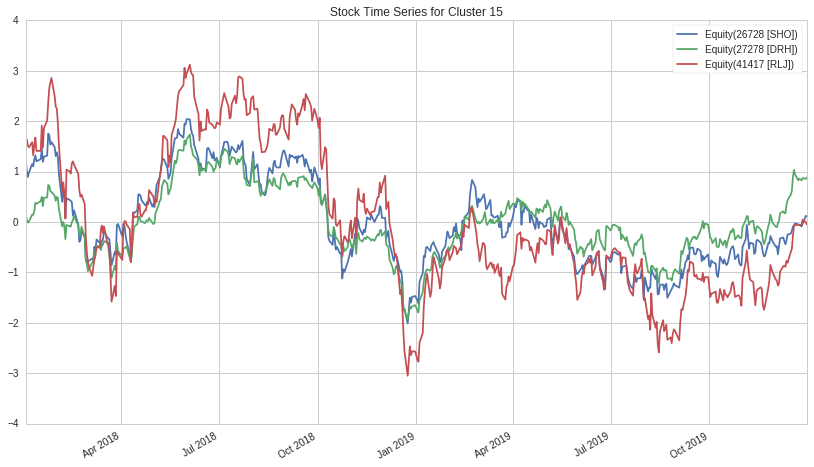

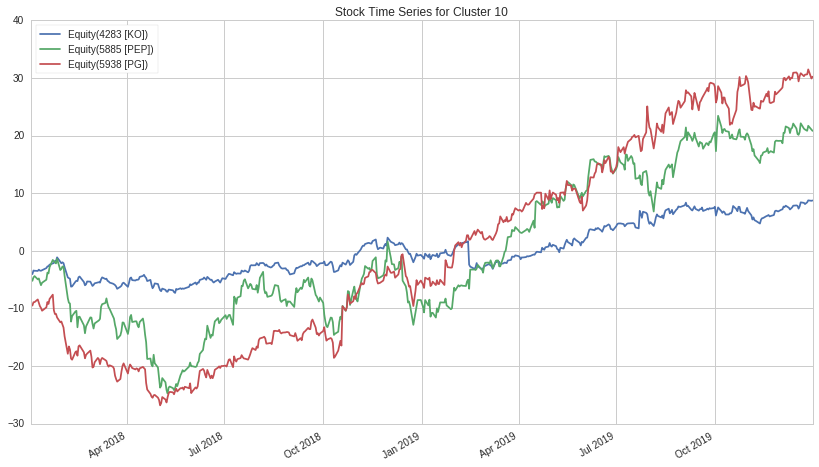

In [82]:
# get the number of stocks in each cluster
counts = clustered_series.value_counts()

# Visualize some clusters
    # Cluster label index => List => Reverse order within the list
cluster_vis_list = list(counts[(counts<20) & (counts>1)].index)[::-1]

# plot a handful of the smallest clusters
for clust in cluster_vis_list[0:3]:
    # Filter equities with the same cluster label
    tickers = list(clustered_series[clustered_series==clust].index)
    means = pricing[tickers].mean()
    data = pricing[tickers].sub(means)
    data.plot(title='Stock Time Series for Cluster %d' % clust)

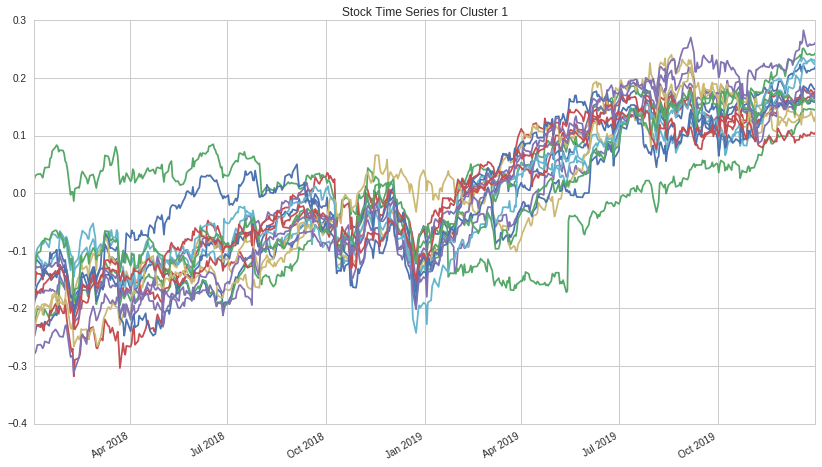

In [40]:
# Select a certain equity and see its cluster
which_cluster = clustered_series.loc[symbols('ADP')]
clustered_series[clustered_series == which_cluster]

tickers = list(clustered_series[clustered_series==which_cluster].index)
means = np.log(pricing[tickers].mean())
data = np.log(pricing[tickers]).sub(means)
data.plot(legend=False, title="Stock Time Series for Cluster %d" % which_cluster);

# Cointegration

In [41]:
# Further filter equities using cointegration

def find_cointegrated_pairs(data, significance=0.05):
    n = data.shape[1]
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            S1 = data[keys[i]]
            S2 = data[keys[j]]
            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < significance:
                pairs.append((keys[i], keys[j]))
    return score_matrix, pvalue_matrix, pairs

In [43]:
CLUSTER_SIZE_LIMIT = 9999
counts = clustered_series.value_counts()
ticker_count_reduced = counts[(counts>1) & (counts<=CLUSTER_SIZE_LIMIT)]
print "Clusters formed: %d" % len(ticker_count_reduced)
print "Pairs to evaluate: %d" % (ticker_count_reduced*(ticker_count_reduced-1)).sum()


cluster_dict = {}
for i, which_clust in enumerate(ticker_count_reduced.index):
    tickers = clustered_series[clustered_series == which_clust].index
    score_matrix, pvalue_matrix, pairs = find_cointegrated_pairs(
        pricing[tickers]
    )
    cluster_dict[which_clust] = {}
    cluster_dict[which_clust]['score_matrix'] = score_matrix
    cluster_dict[which_clust]['pvalue_matrix'] = pvalue_matrix
    cluster_dict[which_clust]['pairs'] = pairs


Clusters formed: 17
Pairs to evaluate: 3016


In [45]:
pairs = []
for clust in cluster_dict.keys():
    pairs.extend(cluster_dict[clust]['pairs'])

pairs

[(Equity(161 [AEP]), Equity(21964 [XEL])),
 (Equity(161 [AEP]), Equity(36098 [AWK])),
 (Equity(612 [ATO]), Equity(1665 [CMS])),
 (Equity(2071 [D]), Equity(2968 [NEE])),
 (Equity(2071 [D]), Equity(5484 [ES])),
 (Equity(2330 [DTE]), Equity(24783 [AEE])),
 (Equity(2351 [DUK]), Equity(5607 [OGE])),
 (Equity(2434 [ED]), Equity(2968 [NEE])),
 (Equity(2434 [ED]), Equity(5484 [ES])),
 (Equity(2434 [ED]), Equity(8140 [WEC])),
 (Equity(2434 [ED]), Equity(21964 [XEL])),
 (Equity(2434 [ED]), Equity(36098 [AWK])),
 (Equity(2637 [ETR]), Equity(2968 [NEE])),
 (Equity(2637 [ETR]), Equity(7011 [SO])),
 (Equity(2968 [NEE]), Equity(6193 [WTRG])),
 (Equity(2968 [NEE]), Equity(7011 [SO])),
 (Equity(5310 [NI]), Equity(5607 [OGE])),
 (Equity(5310 [NI]), Equity(24783 [AEE])),
 (Equity(5607 [OGE]), Equity(24783 [AEE])),
 (Equity(8140 [WEC]), Equity(36098 [AWK])),
 (Equity(21964 [XEL]), Equity(36098 [AWK])),
 (Equity(266 [AJG]), Equity(438 [AON])),
 (Equity(266 [AJG]), Equity(19147 [RSG])),
 (Equity(438 [AON]),

In [47]:
print "We found %d pairs." % len(pairs)

print "In those pairs, there are %d unique tickers." % len(np.unique(pairs))


We found 145 pairs.
In those pairs, there are 114 unique tickers.


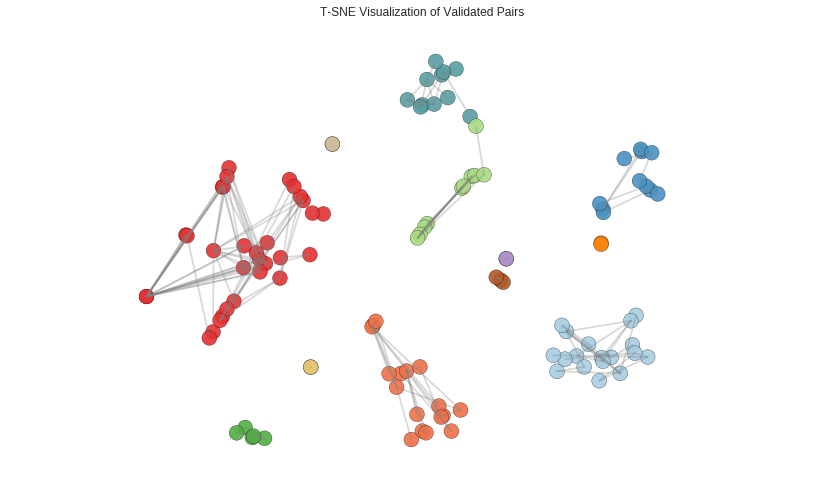

In [48]:
stocks = np.unique(pairs)
X_df = pd.DataFrame(index=returns.T.index, data=X)
in_pairs_series = clustered_series.loc[stocks]
stocks = list(np.unique(pairs))
X_pairs = X_df.loc[stocks]

X_tsne = TSNE(learning_rate=50, perplexity=3, random_state=1337).fit_transform(X_pairs)

plt.figure(1, facecolor='white')
plt.clf()
plt.axis('off')
for pair in pairs:
    ticker1 = pair[0].symbol
    loc1 = X_pairs.index.get_loc(pair[0])
    x1, y1 = X_tsne[loc1, :]

    ticker2 = pair[0].symbol
    loc2 = X_pairs.index.get_loc(pair[1])
    x2, y2 = X_tsne[loc2, :]
      
    plt.plot([x1, x2], [y1, y2], 'k-', alpha=0.3, c='gray');
        
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], s=220, alpha=0.9, c=[in_pairs_series.values], cmap=cm.Paired)
plt.title('T-SNE Visualization of Validated Pairs');
